In [1]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pydicom
from scipy.ndimage import rotate

%matplotlib notebook
plt.rcParams['figure.figsize'] = (16.0, 12.0)

## Make the notebook use full width of display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loading data


In [2]:
lungs = io.imread("lungs.jpg", as_gray=True)
print(lungs.shape)

(569, 600)


# Window/Level

Remember, this is just a way to change how we are visualising the data, it doesn't transform the data itself

1.0 0.0


<IPython.core.display.Javascript object>


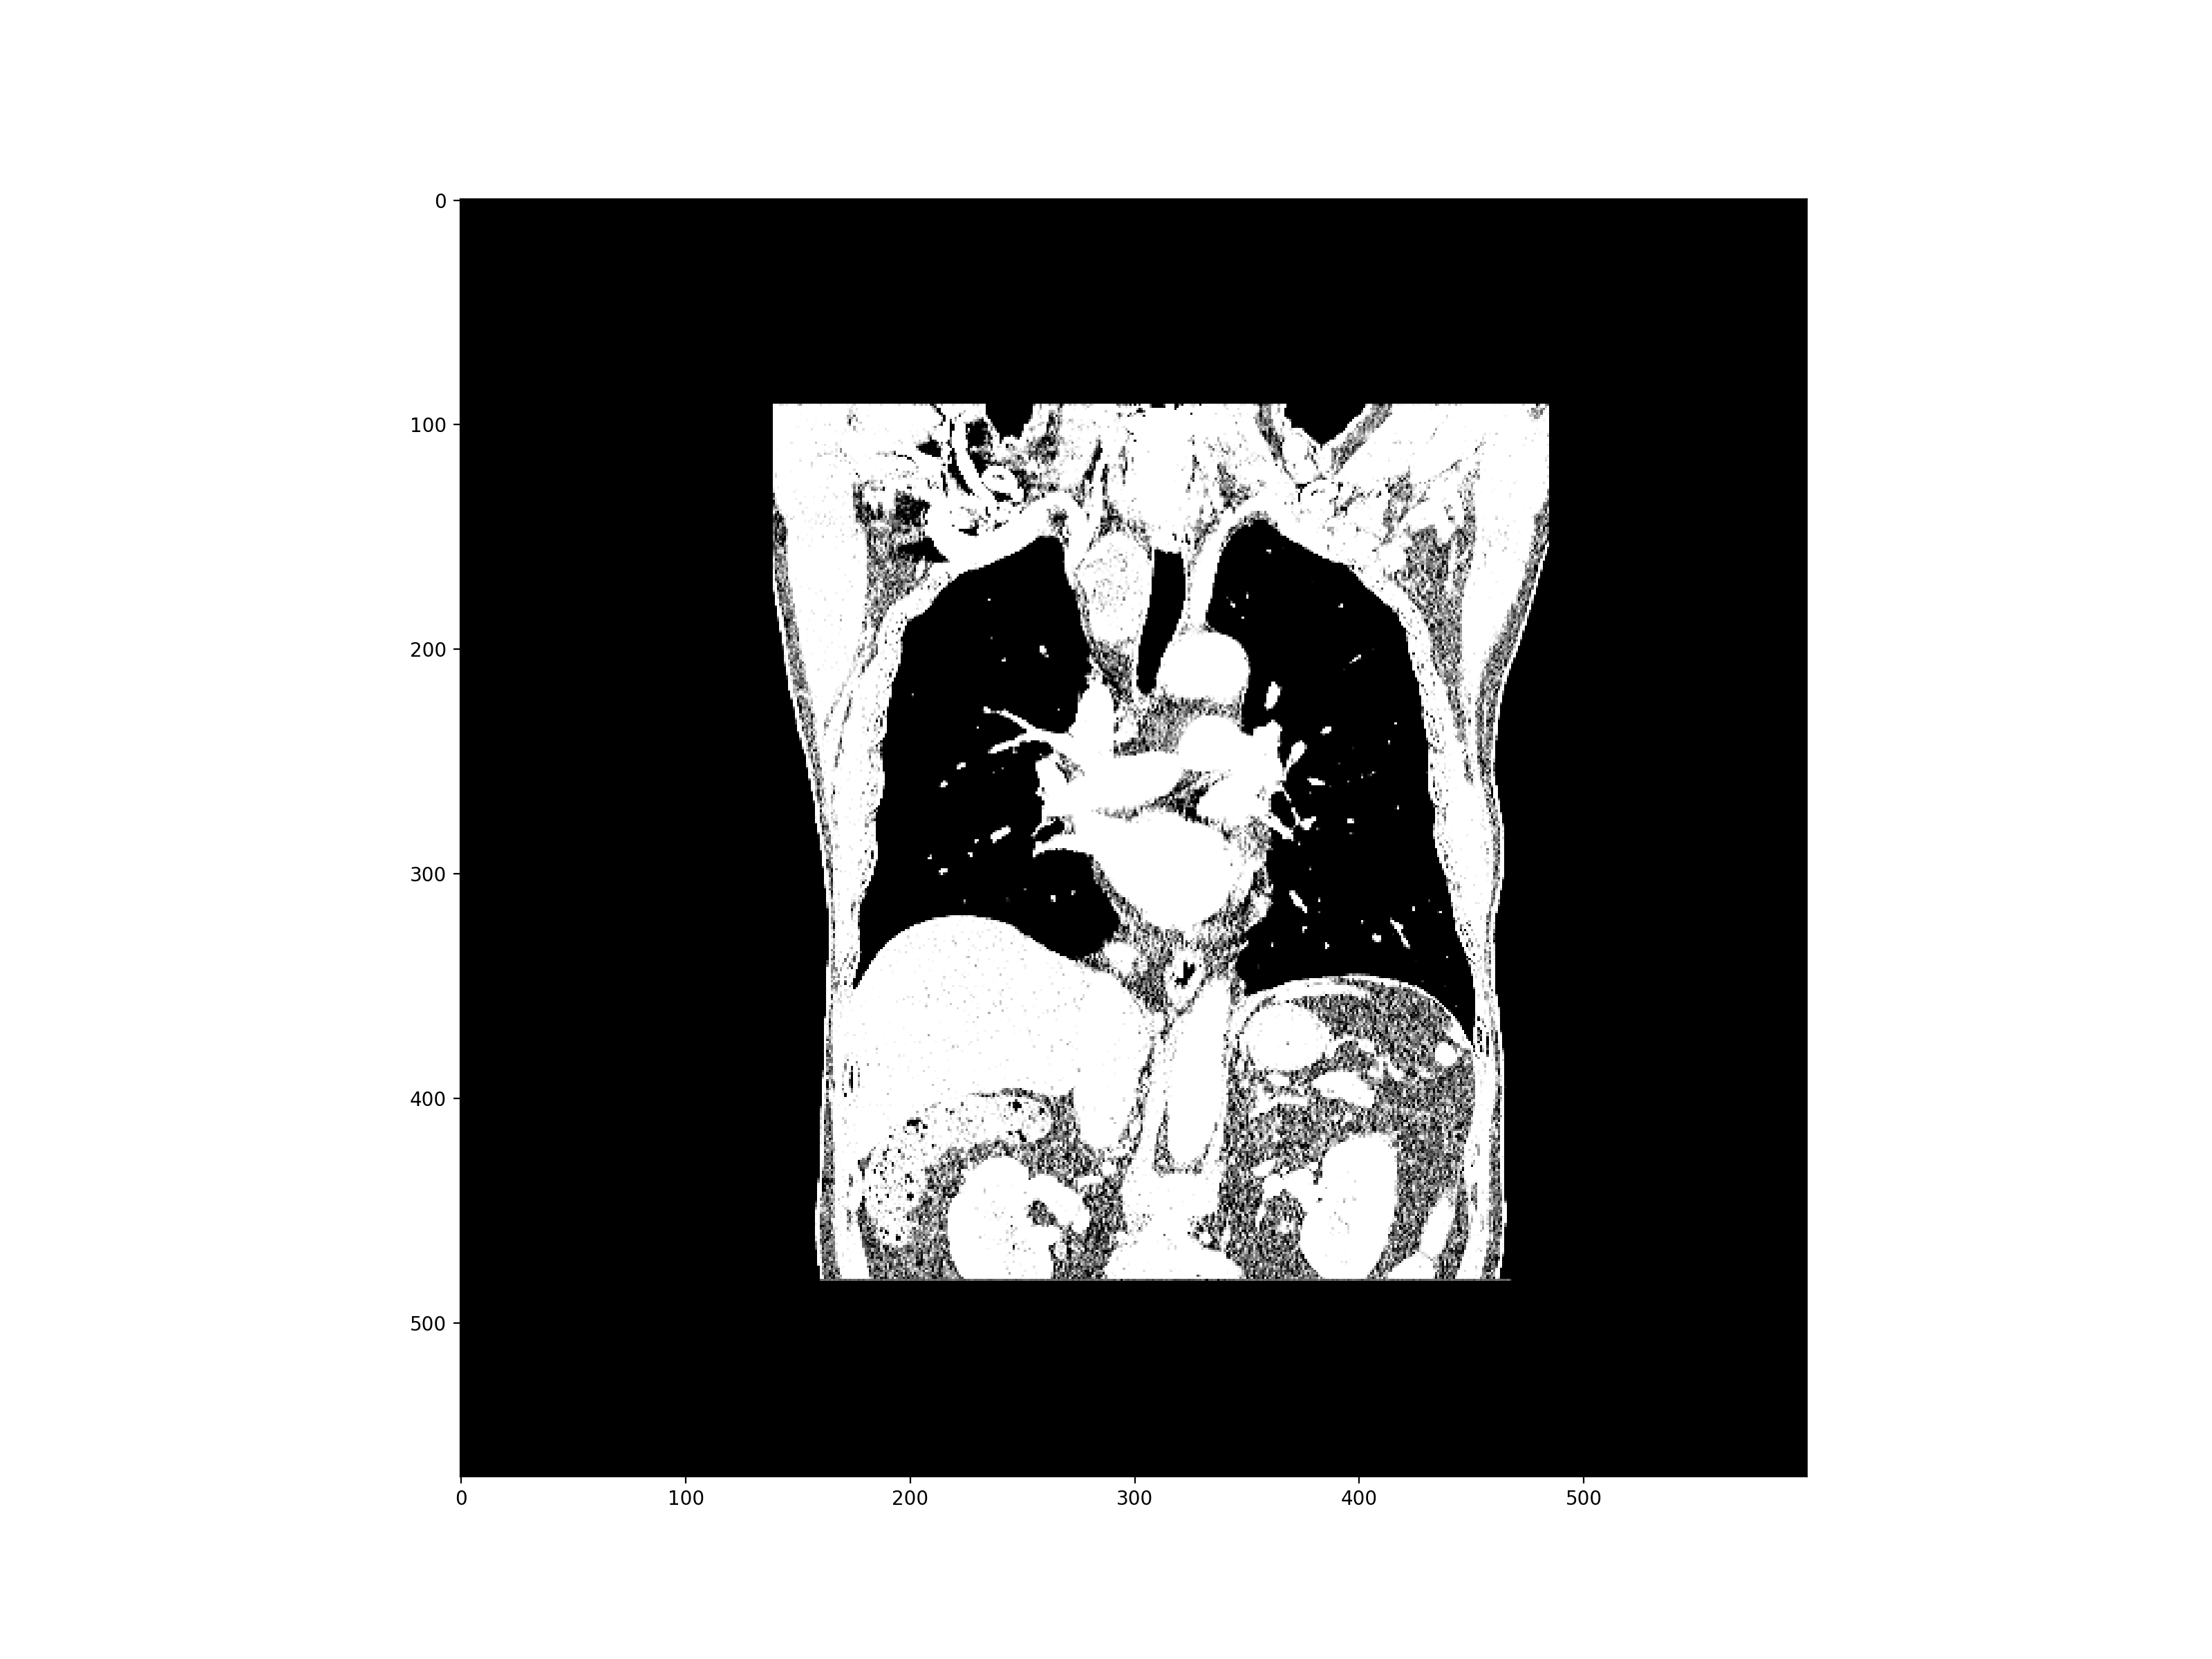

In [3]:
print(lungs.max(), lungs.min())

## Map HU to this range: 
## -1024 = 0
##  3000 = 1
## range = 4024

## From yesterdays practical, you should have figured out what bits of the 0-1 scale correspond to what structures


level = 1000/4024
window = 1000/4024

vis_min = level - window/2
vis_max = level + window/2

plt.imshow(lungs, cmap='Greys_r', vmin=vis_min, vmax=vis_max)

plt.show()



# Threshold

You can use a threshold as a simple segmentation method

In [ ]:
threshold_seg = np.zeros_like(lungs)
threshold_seg[lungs > 2000/4024] = 1 ## This is a one-sided threshold
threshold_seg[lungs < 2300/4024] = 0 ## this makes it a 'top-hat' threshold

## Try tuning this so that only muscle is selected

plt.imshow(threshold_seg, cmap='Greys_r')
plt.show()

# Interpolators

Lets take the lungs image and rotate it through 720 degrees in 10 degree steps. this ought to show how bad the interpolators are

Note, mode is about how the interpolatoe handles the edges, order is about how good the interpolation is, roughly:
 0 = nearest
 1 = linear
 2+ = polynomial
 
It refers to the order of the spline used in interpolation

NB this cell will take a while to run!

try playing with the number of degrees per step. How bad can you make it?

In [ ]:
fig = plt.figure()

ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)

ax0.imshow(lungs, cmap='Greys_r')
ax1.imshow(lungs, cmap='Greys_r')
ax2.imshow(lungs, cmap='Greys_r')

lungs_nn = lungs.copy()
lungs_lin = lungs.copy()
lungs_poly = lungs.copy()

ax20 = fig.add_subplot(234)
ax21 = fig.add_subplot(235)
ax22 = fig.add_subplot(236)

l_nn_show = ax20.imshow(lungs_nn, cmap='Greys_r')
ax20.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")

l_lin_show = ax21.imshow(lungs_lin, cmap='Greys_r')
ax21.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")
l_poly_show = ax22.imshow(lungs_poly, cmap='Greys_r')
ax22.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")
plt.show()   

degrees = 10
for i in range(72):
    print(f"{i},",end='')
    lungs_nn = rotate(lungs_nn, degrees, mode='nearest', order=0, reshape=False)
    lungs_lin = rotate(lungs_lin, degrees, mode='nearest', order=1, reshape=False)
    lungs_poly = rotate(lungs_poly, degrees, mode='nearest', order=2, reshape=False)
    
    l_nn_show.set_data(lungs_nn)
    ax20.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")
    l_lin_show.set_data(lungs_lin)
    ax21.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")

    l_poly_show.set_data(lungs_poly)
    ax22.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")

    fig.canvas.draw()
    
    







# DICOM

Earlier in the notebook, I imported the pydicom module, lets now use it and see how it works

In [ ]:
## There should be a file called 
patientImage = pydicom.read_file("IMG-0004-00001.dcm")

print(patientImage)

fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.imshow(patientImage.pixel_array, cmap='Greys_r')
plt.show()


# Optimisers

This cell will show you how to use an optimizer for a very simple problem - finding the minimum of a function

To do this, we will use a simple optimizer in scipy, the brute force optimiser:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html

This optimiser evaluates the function on a grid of points and homes in on the best value by looking where the function is minimum. There are other, better optimizers, for example differential_evolution, which you could try.

For now, we will define a function (which is equivalent to our 'cost' function) and try to minimise it using brute. I have decided to minimise a simple quadratic with a known root, because it is easy to know if we got the right answer or not.

In the next few cells, I import the optimiser and define the function. Then I plot it over some domain, just to make sure it is doing what I think it should be

Then we use the brute force optimiser to find the root. Note the call looks like `brute(fcn, ((-10.0, 10.0),))`. The ((-10.0, 10.0),) sets the range over which it will look for solutions. One tricky detail here is that brute expects a tuple of tuples - that's why there is an extra comma.

In [ ]:
from scipy.optimize import brute

In [ ]:
def fcn(x):
    return  (x  - 1.7732)**2


def fcn2(x):
    return  0.5*x*(0.5*(x  - 4)**3 - 0.5*(x-1)**2 + 7)


# let x be in the range -10 -> 10, taken at 1000 equally spaced points
domain = np.linspace(-10, 10, 1000)

domain2 = np.linspace(0, 7, 1000)

fig = plt.figure()
plt.plot(domain, fcn(domain))
plt.show()

In [ ]:
## now run brute to find the minimum value

minval = brute(fcn, ((-10.0, 10.0),))

print(minval)

You should see that brute has found the root of the equation pretty accurately. Try:
    
- Changing the root. Does brute work even if it is close to the edge of the domain?
- Changing the range over which brute evaluates the function, what if it deliberately doesn't contain the root?
- Try other optimisers, e.g. differential_evolution
- Try minimizing fcn2. First plot it by doing `plt.plot(domain2, fcn2(domain2))` Do you see any problems?